## Introduction to Detectors

Looking at calibration exposures is one of the key ways to understand CCD behavior. 

Let's start by looking at some bias and flat exposures. Remember a bias is a zero-exposure-time image, so no light actually hits the detector. A flat is an exposure taken with a uniform light source (usually from a light source in the telescope dome, sometimes using the twilight sky).

Then, we'll do some simulations to try to understand the effects of lateral electric fields.

In [1]:
# Start by importing some helpful packages:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval
# I like using ZScale to set the scale of images. This mimics the ZScale function in ds9.
interval = ZScaleInterval()

### Part 1: Measuring Read Noise and Gain
(with credit to Colin Slater for writing this problem)

##### 1. Visually inspecting the data
We're going to be using calibration from Hyper-Suprime Cam (HSC). First, let's take a look at one of the bias exposures: 

In [2]:
# All of the files we will use:
bias1_file = 'detectors_data/HSCA07222508.fits'
bias2_file = 'detectors_data/HSCA07222708.fits'
flat1_file = 'detectors_data/HSCA06113508.fits'
flat2_file = 'detectors_data/HSCA06113708.fits'

In [3]:
bias1 = fits.open(bias1_file)
# Note that a fits file contains a list of "HDU" objects:
print(bias1)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f85883ec2e0>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x7f8551915190>]


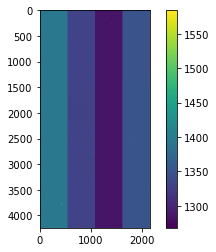

In [18]:
# For these files, the image data is in the second HDU (i.e. index=1) in the fits file:
data = bias1[1].data
vmin, vmax = interval.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax)
plt.colorbar()

...and one of the flats:

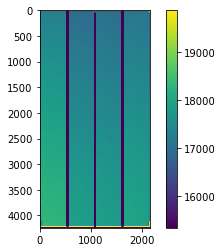

In [19]:
flat1 = fits.open(flat1_file)
data = flat1[1].data
vmin, vmax = interval.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax)
plt.colorbar()

With the scaling I used, the bias image is dominated by the amplifier differences. You can see that HSC detectors have four amplifiers. The corresponding segments are separated by overscan regions, which are visible in the flat image. The pixel limits of the segments are included in the header of the fits files. Below is a convenience function to read a file and return a list containing arrays with the individual segments:

In [15]:
def getSegments(fitsFile, extension=1, segments=4):
    hdus = fits.open(fitsFile)
    header = hdus[extension].header
    data = hdus[extension].data
    
    data_segments = []
    for s in range(1, segments + 1):
        ampxMin = header[f'T_EFMN{s}1']
        ampxMax = header[f'T_EFMX{s}1']
        ampyMin = header[f'T_EFMN{s}2']
        ampyMax = header[f'T_EFMX{s}2']
        data_s = data[ampyMin:ampyMax, ampxMin:ampxMax]
        data_segments.append(data_s)
    return data_segments

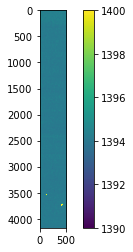

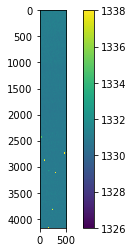

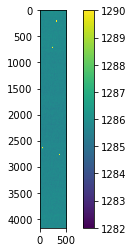

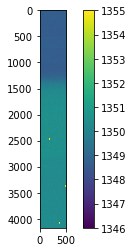

In [26]:
# Let's take a look at a single segment (you may want to set the ylim to get a closer look):
bias1_segments = getSegments(bias1_file)
print(bias1_segments[1])
for i in range(4):
    data = bias1_segments[i]
    vmin, vmax = interval.get_limits(data)
    plt.imshow(data, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

##### 2. Looking for structure

The bias looks mostly like Gaussian noise, but if you look carefully some parts of the image look like they have some "structure". Let's make a few plots: try plotting the mean of the data along columns in one plot, and along rows in another.

Start with just a single amplifier, but if you like you can learn more by plotting each amplifier as a different line. Hint: the amplifiers each have different mean levels that you probably want to subtract off.

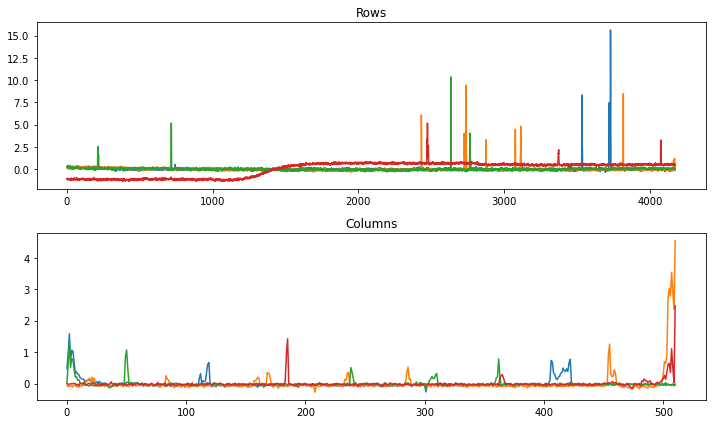

In [34]:
fig, axs = plt.subplots(2, figsize=[10,6])
for i in range(4):
    data = bias1_segments[i]
    row = data.mean(1)
    col = data.mean(0)
    axs[0].plot(row-row.mean())
    axs[0].set_title('Rows')
    axs[1].plot(col-col.mean())
    axs[1].set_title('Columns')
    fig.tight_layout()

These "simple" bias frames turn out to have a lot of structure in them, particularly at the start of columns. This isn't something we can dive much further into, because it's really an electronics problem (that was known about at the time). It's also worth noting that it's fractionally a small effect. We will have to make sure our subsequent analyses are not affected by the issue though.

##### 3. Measure the noise:

Bias images usually have some repeatable structure to them, so a useful trick is to use the difference of two bias frames taken close in time. Let's measure the standard deviation for the differences between the biases, doing so separately for each amplifier. This isn't the final read noise value yet, because it's still in ADU and not in electrons. We will store the results in a dictionary for later use.

In [35]:
bias1_segments = getSegments(bias1_file)
bias2_segments = getSegments(bias2_file)

In [36]:
# Question
measured_stddevs = {}

for i in range(4):
    hdu_difference = bias2_segments[i] - bias1_segments[i]
    
    stddev = np.std(hdu_difference)

    measured_stddevs[i] = stddev
print(measured_stddevs)

{0: 5.876343340326068, 1: 6.9160100121614345, 2: 7.5368915392037295, 3: 3.6600440141954556}


##### 4. Measure the gain

We have just one more step before we can report the read noise. We need to measure the gains so we can convert the noise in ADU into electrons. To do that, we're going to use the trick we saw at the start of this notebook. We need to add two things though: we want to use pairs of images, to cancel out any fixed spatial patterns, and we need images with significant counts in them so that we're not just measuring read noise. The formula we want to implement is thus:

$$ \frac{1}{\mathrm{gain}} = \langle \frac{(I_{1} - I_{2})^2}{I_{1} + I_{2}} \rangle
$$  
 
where $I_{1}$ and $I_{2}$ are the pixel values from each image, and the $\langle$ $\rangle$ brackets denote taking the mean of this ratio over all pixels.



In [37]:
# We will use the flat field image files listed above:
flat1_segments = getSegments(flat1_file)
flat2_segments = getSegments(flat2_file)

Since each amplifier can have a slightly different gain, we want to run this per-HDU and output a table of values. Since we're looping over the HDUs, we can also print the finished read noise values at the same time. Note that those have a factor of $\sqrt{2}$ because we took the difference of two bias frames, so the noise is greater than a single image.

In [40]:
# Question
for s in range(4):
    flat1_data = flat1_segments[s]
    flat2_data = flat2_segments[s]
    
    debiased_flat1 = flat1_data-bias1_segments[s]
    debiased_flat2 = flat2_data-bias1_segments[s]#can use any bias, better to use mean though
    
    squared_noise = (debiased_flat2-debiased_flat1)**2
    summed_intensity = debiased_flat2+debiased_flat1
    
    # Some pixels with low counts are likely artifacts and can skew the measurement.
    # It helps to only keep pixels that have significant flux; you can experiment with this cutoff
    ok_values = summed_intensity > 5000

    # Remember that as we defined gain above, the formula returns 1/gain.
    reciprocal_gain = (squared_noise[ok_values]/summed_intensity[ok_values]).mean()
    
    read_noise = measured_stddevs[s]/reciprocal_gain/np.sqrt(2)

    print(s, reciprocal_gain, 1/reciprocal_gain, read_noise)

0 0.2913264013663027 3.432575953672795 14.263047238552119
1 0.286639982179342 3.4886968398369844 17.060975029274378
2 0.28972130733418333 3.4515928745500766 18.39487459681801
3 0.2928567486916655 3.4146387422092532 8.837228281201952


I got values of about 3.4 for the gain and read noise of around 8 - 18 e-. Did those work out for you?

### Part 2: The Brighter-Fatter Effect 

The brighter-fatter effect means that electrons already in a pixel well effectively change the size of the pixel boundaries. We can model this effect to see why it happens. We can approximate this effect following Coulomb's Law:
$$ \delta(r) = \sum_{i, j} c Q_{i, j} / r^{2} $$
where $\delta(r)$ is the displacement of a pixel corner at distance $r$, $c$ is some constant, $Q$ is the charge in pixel $i, j$, and $r$ is the distance between the pixel corner and the charge.

We can build a model that shows the PSF distortion due to the brighter-fatter effect, using a 1d model for simplicity:

##### 1. Simple case
First, let's approximate the effect of a test charge in one pixel on the neighboring pixels.


In [ ]:
# Set a semi-arbitrary value for the coefficient c. (The value shown here will result in a much bigger distortion than what is typically seen,
# but makes visualization easier.)
c = .02
# Make an array of the pixel corners (you can change this, but usually it's nice to have an odd number of pixels):
pixel_corners = np.arange(0, 22)
# An array of the pixel centers is also convenient to have
pixel_centers = pixel_corners+0.5

# Approximate that charge is in the center of the pixel:
charge_location = # choose something in the range of your number of pixels
current_charge = 1

distortions = # complete
# Plot the distortions as a function of the pixel corners:

# complete


Now, let's calculate where charge ends up with incident light with a PSF centered on the same location as above. The resulting charge will be 

$$ Q_{i} = \int_{x_i}^{x_j} \psi(x) dx
$$
where $Q_{i}$ is the resulting charge in pixel $i$, $x_{i}$ and $x_j$ are the two corners of pixel $i$, and $\psi(x)$ is the PSF of the incoming light.

In [ ]:
# We will model the incoming light as a Moffat PSF
def MoffatPSF(x, x0):
    beta = 2.5
    half_light_radius = 4.
    tmp = np.power(0.5,1./(1-beta)) - 1
    r0 = half_light_radius / np.sqrt(tmp)
    norm = (beta-1) / (np.pi * r0**2)
    
    rsq = np.square(x - x0)
    result = norm * np.power(1+rsq/(r0**2), -beta)
    return result


In [ ]:
distorted_pixel_corners = pixel_corners + distortions
distorted_pixel_centers = # complete
psf_center = 10.5

# Calculate the distribution of the incident charge using the equation for Q_i above
new_charge = # complete
# Compare the distorted distribution with an undistorted distribution:
plt.plot( # complete
plt.plot( # complete


##### 2. Realistic case (bonus question)
Now, let's model a more realistic situation in which there are existing charges in multiple pixel wells, distributed accorded to the PSF, with amplitude corresponding to a given flux:

In [ ]:
# Again assume the center of the distribution is at 10.5:

flux = 200
x0 = 10.5
current_charge = flux * MoffatPSF(pixel_centers, x0)


Now, let's look at the effect of this charge distribution on incoming electrons. This time, we need to consider the effect of the charges in each pixel on all the other pixels:

In [ ]:
distortions = []
for pp, pixel_center in enumerate(pixel_centers):
    distortions_pp = # complete
    distortions.append(distortions_pp)
total_distortions = # complete
plt.plot( # complete

Again, let's see how this pixel distortion affects the distribution of incoming electrons:

In [ ]:
distorted_pixel_corners = # complete
distorted_pixel_centers = # complete
psf_center = 10.5

new_charge = # complete
# Plot distorted vs undistorted distributions:
plt.plot( # complete
plt.plot( # complete

Finally, we can use this to model what happens over the course of an exposure. In this case, we start with no charge in the pixel wells and no distortions. Then, as charge builds up at the location of sources, incoming electrons experience more and more deflection due to lateral fields. In practice, we can approximate this by breaking the exposure time into steps, and adding up the charge that accumulates in each pixel during each time step:

In [ ]:
# Again assume the center of the distribution is at 10.5:
flux = 2000
x0 = 10.5
timeSteps = 5
current_charge = np.zeros(len(pixel_centers))
for t in range(timeSteps):
    flux_t = flux / timeSteps

    distortions = []
    for pp, pixel_center in enumerate(pixel_centers):
        # complete

You should see that the distribution of charges gets broader and broader in each time step.